In [1]:
import numpy as np
import pandas as pd

from scipy import stats, special, spatial

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import importlib.util
import os

import warnings
warnings.filterwarnings('ignore')

#s.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [2]:
## datasets
folder = '../data/'

# Data
fn1 = 'scerevisiae_tpm_full_cut5.csv'
fn2 = 'scerevisiae_accessions.tsv'
fn3 = 'scerevisiae.rsd1.lmbda_22.npz'
fn4 = 'Saccharomyces_cerevisiae.R64-1-1.regions.csv'

fn5 = 'organisms_deep_results.csv'

fname_data1 = folder+'scerevisiae.rsd1.lmbda_22.npz'
fname_module1 = folder+'Model_C3F2all.py'
fname_p1 = folder+'scerevisiae_good_rsd1_lmbda22_Model_C3F2all_1234_c008090fd8e4b9971fe71eed502c9f7b_best.p'
fname_weights1 = folder+'scerevisiae_good_rsd1_lmbda22_Model_C3F2all_1234_c008090fd8e4b9971fe71eed502c9f7b_best'

fn6 = 'df_Keren2013_predictions.csv'
fn7 = 'df_Yamanishi2013_predictions.csv'


In [3]:
def load_data(fname):
    # X is multi-variable array
    # Y contains single variable - fix shape for Keras

    npzfile = np.load(fname,allow_pickle=True)
    Xh_train = npzfile['arr_0']
    Xh_test = npzfile['arr_1']
    Xv_train = npzfile['arr_2'][:,8:]
    Xv_test = npzfile['arr_3'][:,8:]
    Y_train = npzfile['arr_4']
    Y_test = npzfile['arr_5']
    names_train = npzfile['arr_6']
    names_test = npzfile['arr_7']

    X_train = list()
    X_train.append(Xh_train)
    #X_train.append(Xv_train)
    X_test = list()
    X_test.append(Xh_test)
    #X_test.append(Xv_test)

    Y_train = Y_train.astype(np.float32).reshape((-1,))
    Y_test = Y_test.astype(np.float32).reshape((-1,))

    return (np.concatenate((Y_train, Y_test)), 
            np.concatenate((names_train,names_test)), 
            np.concatenate((Xv_train,Xv_test)))

# load modules - POC model
def load_module(model_path):
    '''loads module containing models given path'''
    spec = importlib.util.spec_from_file_location('module',model_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def get_rsd(x):
    return x.std()/x.mean()

def dynamic_range(x):
    return np.log10(max(x)-min(x))

def signal2noise(x):
    return np.median(x)/np.std(x)

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))

def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

# Analysis RNAseq data

In [4]:
# load data

df = pd.read_csv(folder+fn1)

rsd = df.groupby('gene_id').TPM.apply(get_rsd)
rsd = rsd.reset_index()
rsd.columns = ['gene_id','rsd']
df = df.merge(rsd,on='gene_id',how='left')

med = df.groupby('gene_id').TPM.median()
med = med.reset_index()
med.columns = ['gene_id','median']
df = df.merge(med,on='gene_id',how='left')

df.head()


,gene_id,sample_id,gene_len,TPM,rsd,median
0,YAL005C,SRR7242111,2313.0,973.837378,1.065374,545.49274
1,YAL005C,SRR7426367,2313.0,339.383558,1.065374,545.49274
2,YAL005C,SRR7242216,2313.0,232.165401,1.065374,545.49274
3,YAL005C,SRR3140106,2313.0,659.379465,1.065374,545.49274
4,YAL005C,SRR5448426,2313.0,337.381832,1.065374,545.49274


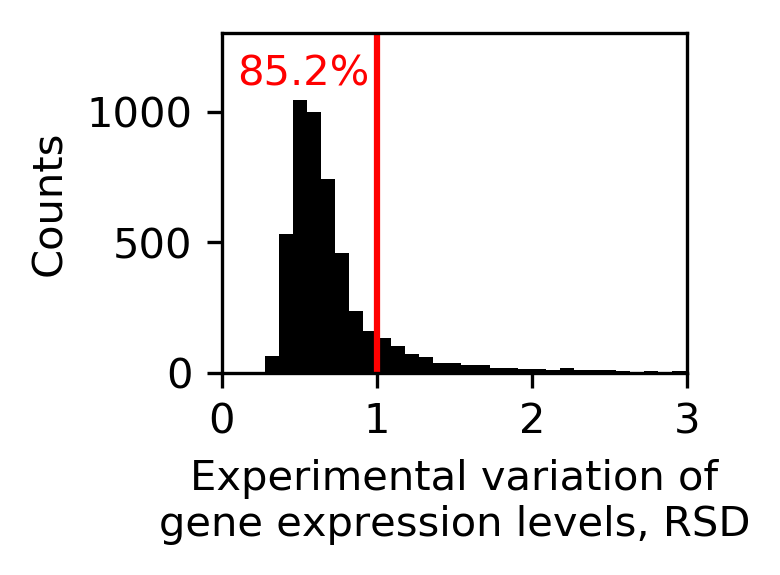

In [5]:
# histogram RSD1

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,1.5))
plt.hist(rsd[rsd.rsd<=3].rsd,bins=30,color='k')
plt.plot([1,1],[0,2000],'r')
plt.ylim(0,1300)
plt.xlim(0,3)
plt.ylabel('Counts')
plt.xlabel('Experimental variation of\ngene expression levels, RSD')
ann = 100*(sum(rsd.rsd <= 1)/rsd.shape[0])
plt.annotate('%.1f'%(ann)+'%',xy=(0.1,1100),
            color='r',size=10)

plt.savefig('f1b.svg')

150493.75


<Figure size 3000x1800 with 0 Axes>

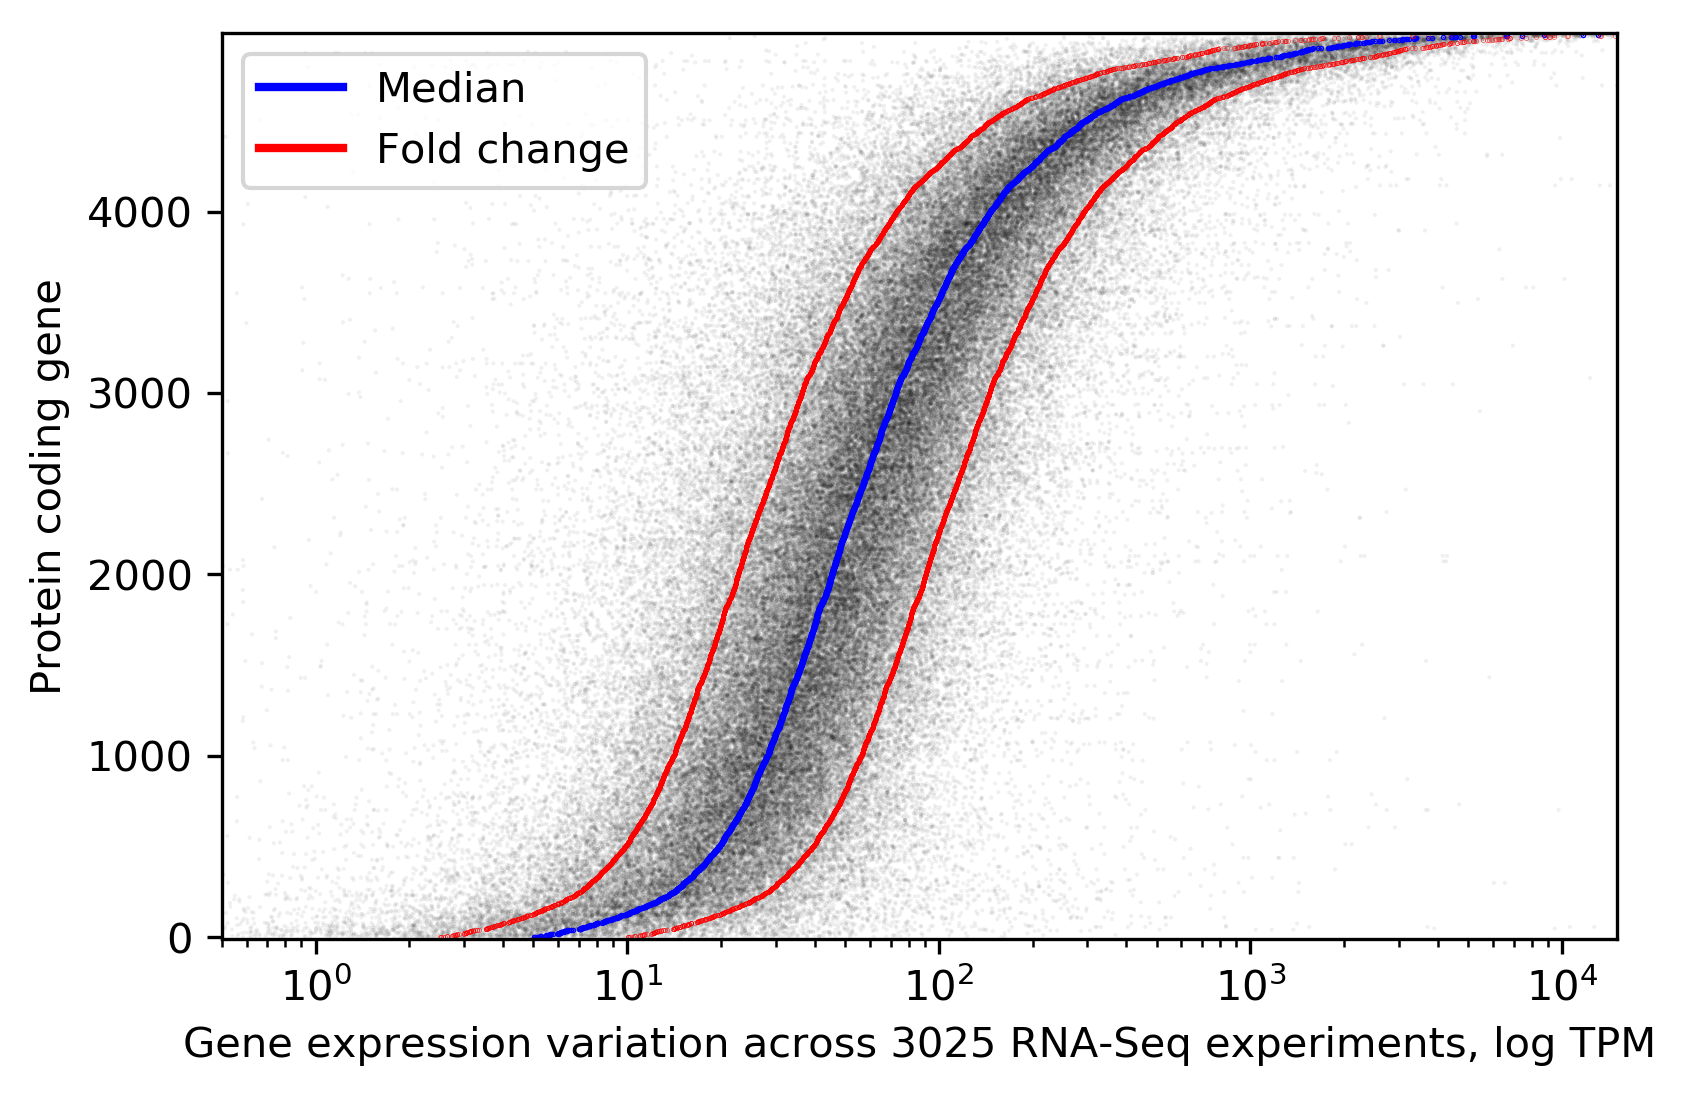

In [6]:
# fig 1B S curve and distribution

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(10,6))
print(df.shape[0]*0.01)

# rename
ren_sort = df.sort_values(by='median').gene_id.unique()
ren_dict = dict(zip(ren_sort, range(len(ren_sort))))
df['gene_num'] = df.gene_id.map(ren_dict)
med['gene_num'] = med.gene_id.map(ren_dict)

(df.sample(frac=0.01,random_state=77)
 .plot.scatter(x='TPM',y='gene_num',
            c='k',s=1, 
            edgecolor='',alpha=0.06,
            figsize=(6,4)
            ))
plt.scatter(med['median'],med.gene_num,color='b',s=0.1)

plt.scatter(med['median']*2,med.gene_num,color='r',s=0.01)
plt.scatter(med['median']/2,med.gene_num,color='r',s=0.01)

plt.xscale('log')
plt.xlim(1-1/2,10000+10000/2)
plt.ylim(-10,df.gene_num.max()+10)
plt.xlabel('Gene expression variation across 3025 RNA-Seq experiments, log TPM')
plt.ylabel('Protein coding gene')

custom_lines = [Line2D([0], [0], color='b', lw=2),
               Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Median','Fold change'],loc=2)

plt.savefig('f1a.svg')

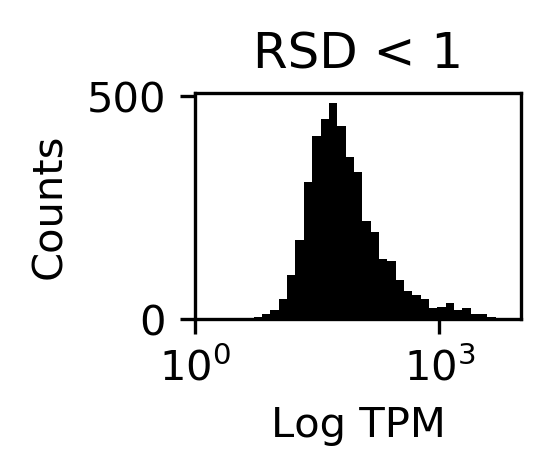

In [7]:
# distribution inset

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(1.4,1))
bmin, bmax = 1, 10000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(df[df.rsd<=1].groupby('gene_id').TPM.median(), 
         bins = logbins,color='k')
plt.xscale('log')
plt.xlim(bmin,bmax)
#plt.ylim(1,)
plt.title('RSD < 1')
plt.ylabel('Counts')
plt.xlabel('Log TPM')

plt.savefig('f1a_ins.svg')

340.441877602682


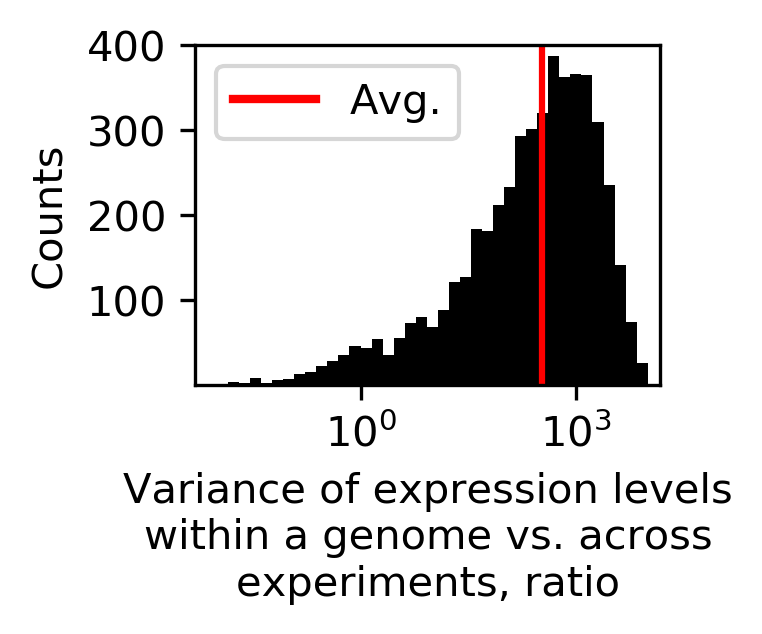

In [8]:
# histogram variance genes

# var_all = df[df.rsd<=1].TPM.var()
# var = df[df.rsd<=1].groupby('gene_id').TPM.apply(lambda x: var_all/np.var(x))

var_all = df.TPM.var()
var = df.groupby('gene_id').TPM.apply(lambda x: var_all/np.var(x))

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,1.5))
#var.hist(bins = 100)
bmin, bmax = 0.01, 10000
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(var, bins = logbins,color='k')
plt.plot([var.median(),var.median()],[0,1000],'r')
plt.xscale('log')
plt.xlim(bmin-bmin/2,bmax+bmax/2)
plt.ylim(1,400)
plt.ylabel('Counts')
plt.xlabel('Variance of expression levels\nwithin a genome vs. across\nexperiments, ratio')

custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'],loc=2)

print(var.median())
#plt.tight_layout()
plt.savefig('f1c.svg')

In [9]:
# Quantify amount of experiments in data

df_exp = pd.read_csv(folder+fn2, sep='\t')
df_exp.head()

df_exp[df_exp.SRR_accession.isin(df.sample_id)].experiment_title.unique().shape[0]#/df.sample_id.unique().shape[0]
#df_exp[df_exp.SRR_accession.isin(df.sample_id)].experiment_title.head()


2365

# Dynamic range data yeast

In [10]:
# note: memory intensive

df = pd.read_csv(folder+fn1)
print(df.shape)

Y, gene_names, cf = load_data(folder+fn3)

df_rsd1 = df.set_index('gene_id').loc[gene_names].reset_index()


(15049375, 4)


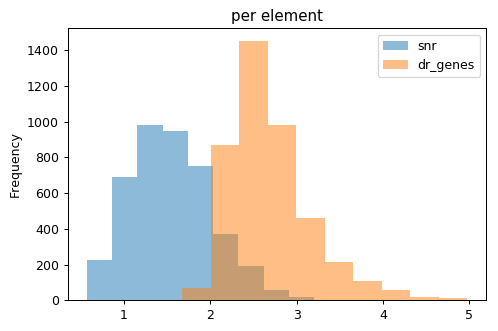

In [11]:
mpl.rcParams['figure.dpi'] = 90

df_ranges = (df_rsd1.groupby('gene_id')['TPM']
             .apply(np.median)
             .reset_index()
             .rename(columns={'TPM':'median'})
            )
df_ranges['var'] = df_rsd1.groupby('gene_id')['TPM'].apply(np.var).values
df_ranges['dr_genes'] =  df_rsd1.groupby('gene_id')['TPM'].apply(dynamic_range).values
df_ranges['snr'] =  df_rsd1.groupby('gene_id')['TPM'].apply(signal2noise).values
df_ranges.head()

df_ranges.snr.plot.hist(alpha=0.5)
df_ranges.dr_genes.plot.hist(alpha=0.5)
plt.legend(['snr','dr_genes'])
plt.title('per element')
plt.show()

In [12]:
# all median except var(median)
df_summary = df_ranges.median(axis=0)
df_summary['median_var'] = df_ranges['median'].var()
df_summary['dr_all'] = dynamic_range(df_ranges['median'].values)
df_summary['dr_ratio'] = dynamic_range(df_ranges['median'].values)/df_ranges.median(axis=0).dr_genes
df_summary


median            58.870923
var             1494.163310
dr_genes           2.597693
snr                1.509976
median_var    351181.118148
dr_all             4.274398
dr_ratio           1.645460
dtype: float64

# Regions sizes

In [13]:
regions = pd.read_csv(folder+fn4,sep=';')
regions.head()

,Unnamed: 0,gene_id,mrna_id,cds_list,5utr_list,3utr_list,cstart,cend,strand,seq_id,cds_len,ostart,oend,prom_list,term_list,prom_full_list,term_full_list,5utr_len,3utr_len
0,0,YAL067C,YAL067C_mRNA,"[array([7235, 9016])]","[array([9016, 9260])]","[array([7276, 7235])]",7235,9016,-,I,1781,7276,9260,"[array([ 9260, 10259])]","[array([6777, 7276])]","[array([ 8760, 10259])]","[array([6777, 7776])]",244,0
1,1,YAL062W,YAL062W_mRNA,"[array([31567, 32940])]","[array([31152, 31567])]","[array([32940, 32984])]",31567,32940,+,I,1373,31152,32984,"[array([30153, 31152])]","[array([32984, 33483])]","[array([30153, 31652])]","[array([32484, 33483])]",415,44
2,2,YAL061W,YAL061W_mRNA,"[array([33448, 34701])]","[array([33360, 33448])]","[array([34701, 34896])]",33448,34701,+,I,1253,33360,34896,"[array([32361, 33360])]","[array([34896, 35395])]","[array([32361, 33860])]","[array([34396, 35395])]",88,195
3,3,YAL060W,YAL060W_mRNA,"[array([35155, 36303])]","[array([35096, 35155])]","[array([36303, 36392])]",35155,36303,+,I,1148,35096,36392,"[array([34097, 35096])]","[array([36392, 36891])]","[array([34097, 35596])]","[array([35892, 36891])]",59,89
4,4,YAL059W,YAL059W_mRNA,"[array([36509, 37147])]","[array([36544, 36509])]","[array([37147, 37328])]",36509,37147,+,I,638,36544,37328,"[array([35545, 36544])]","[array([37328, 37827])]","[array([35545, 37044])]","[array([36828, 37827])]",0,181


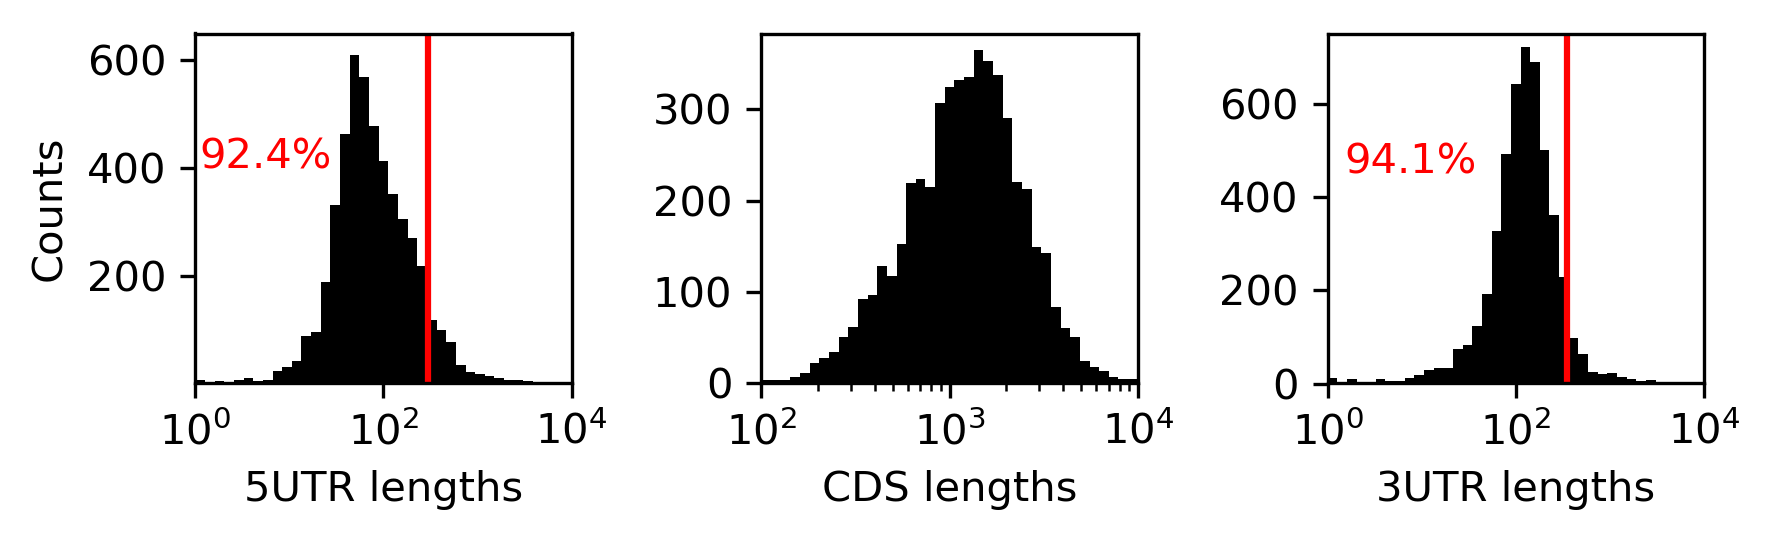

In [14]:
# plot

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,1.9)) #(6,1.6)
plt.subplot(1,3,1)

bmin, bmax = 1, 10000.0
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(regions['5utr_len'], bins = logbins,color='k')
plt.plot([300,300],[0,1000],'r')
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(1,650)
plt.ylabel('Counts')
plt.xlabel('5UTR lengths')

ann = 100*(sum(regions['5utr_len'] <= 300)/regions['5utr_len'].shape[0])
plt.annotate('%.1f'%(ann)+'%',xy=(1.1,400),
            color='r',size=10)

plt.subplot(1,3,2)
bmin, bmax = 100, 10000.0
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(regions['cds_len'], bins = logbins,color='k')
plt.xscale('log')
plt.xlim(100,10000)
plt.xlabel('CDS lengths')

plt.subplot(1,3,3)
bmin, bmax = 1, 10000.0
logbins = 10 ** np.linspace(np.log10(bmin), np.log10(bmax), 40)
plt.hist(regions['3utr_len'], bins = logbins,color='k')
plt.plot([350,350],[0,1000],'r')
plt.xscale('log')
plt.xlim(1,10000)
plt.ylim(1,750)
plt.xlabel('3UTR lengths')

ann = 100*(sum(regions['3utr_len'] <= 350)/regions['3utr_len'].shape[0])
plt.annotate('%.1f'%(ann)+'%',xy=(1.5,450),
            color='r',size=10)

plt.tight_layout()
plt.savefig('f1d.svg')

# Results yeast modeling and exp. validation

In [15]:
## load data and model

module = load_module(fname_module1)

# load p
p = pd.read_csv(fname_p1,sep=';')
p = p.iloc[0]
p.drop(['path','overfit'],inplace=True)
print(p.shape)

# load data
X_train, X_test, Y_train, Y_test = module.load_data(fname_data1) 
# Y = np.concatenate((Y_train, Y_test))
# X = np.concatenate((X_train[0], X_test[0]))
print(len(X_test))
print(len(Y_test))

# model
input_shapes = [sl.shape[1:] for sl in X_train]
model = module.POC_model(input_shapes, p)
# set weights model 1
print("Loading model 1 from disk..")
model.load_weights(fname_weights1)


Using TensorFlow backend.


(42,)
2
425
Loading model 1 from disk..


In [16]:
# predict Ypred

Y_pred = model.predict(X_test)

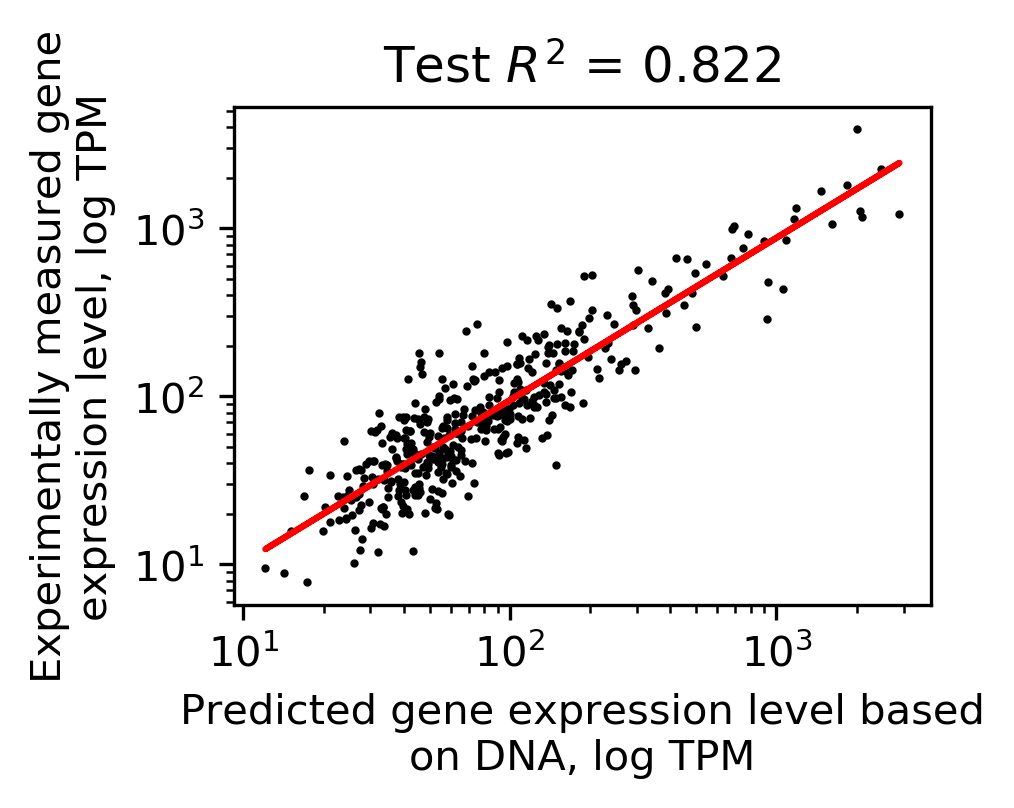

In [17]:
# scatter ypred ytrue

df_ys = pd.DataFrame([item for el in Y_test for item in el],columns=['ytrue'])
df_ys['ypred'] = [item for el in Y_pred for item in el]
df_ys.head()
r2 = coeff_determination(df_ys.ytrue.values,df_ys.ypred.values)

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))
y = df_ys[df_ys > 0].dropna().ytrue.apply(boxtpm,lmbda=0.22).values
x = df_ys[df_ys > 0].dropna().ypred.apply(boxtpm,lmbda=0.22).values

plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')

plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
# plt.ylim(-0.001,0.1)
plt.ylabel('Experimentally measured gene\nexpression level, log TPM')
plt.xlabel('Predicted gene expression level based\non DNA, log TPM')

#_,_,rvalue, pvalue,_ = stats.linregress(x,y)
plt.title('Test $R^2$ = '+str("%.3f" % r2)) #+', $r$ = '+str("%.3f" % rvalue))
#print(fix_pvals(pvalue))

plt.savefig('f1f.svg')

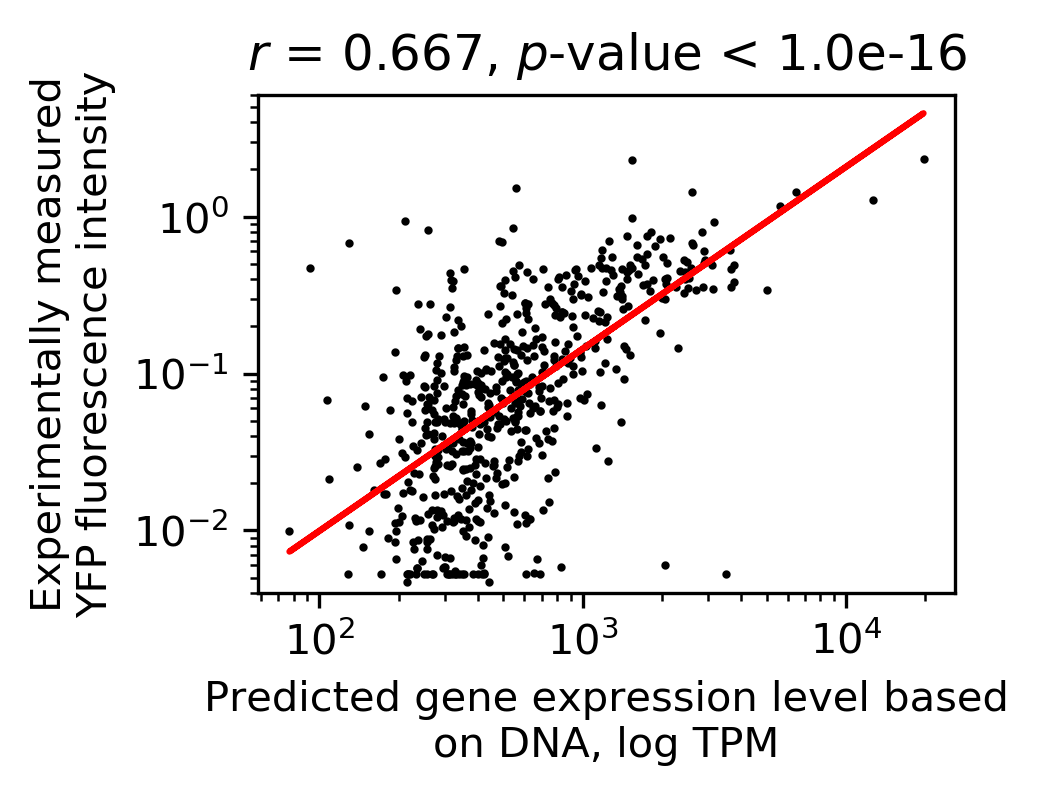

In [18]:
# scatter exp Keren 2013

df_keren = pd.read_csv(folder+fn6)

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,2.2))
x = df_keren.ytpm.values
y = df_keren['median'].values

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
plt.ylim(0.004,6)
plt.ylabel('Experimentally measured\nYFP fluorescence intensity')
plt.xlabel('Predicted gene expression level based\non DNA, log TPM')

# plt.title('$R^2$ = '+str("%.3f" % rvalue**2))
plt.title('$r$ = '+str("%.3f" % rvalue)+', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

plt.savefig('f1g.svg')

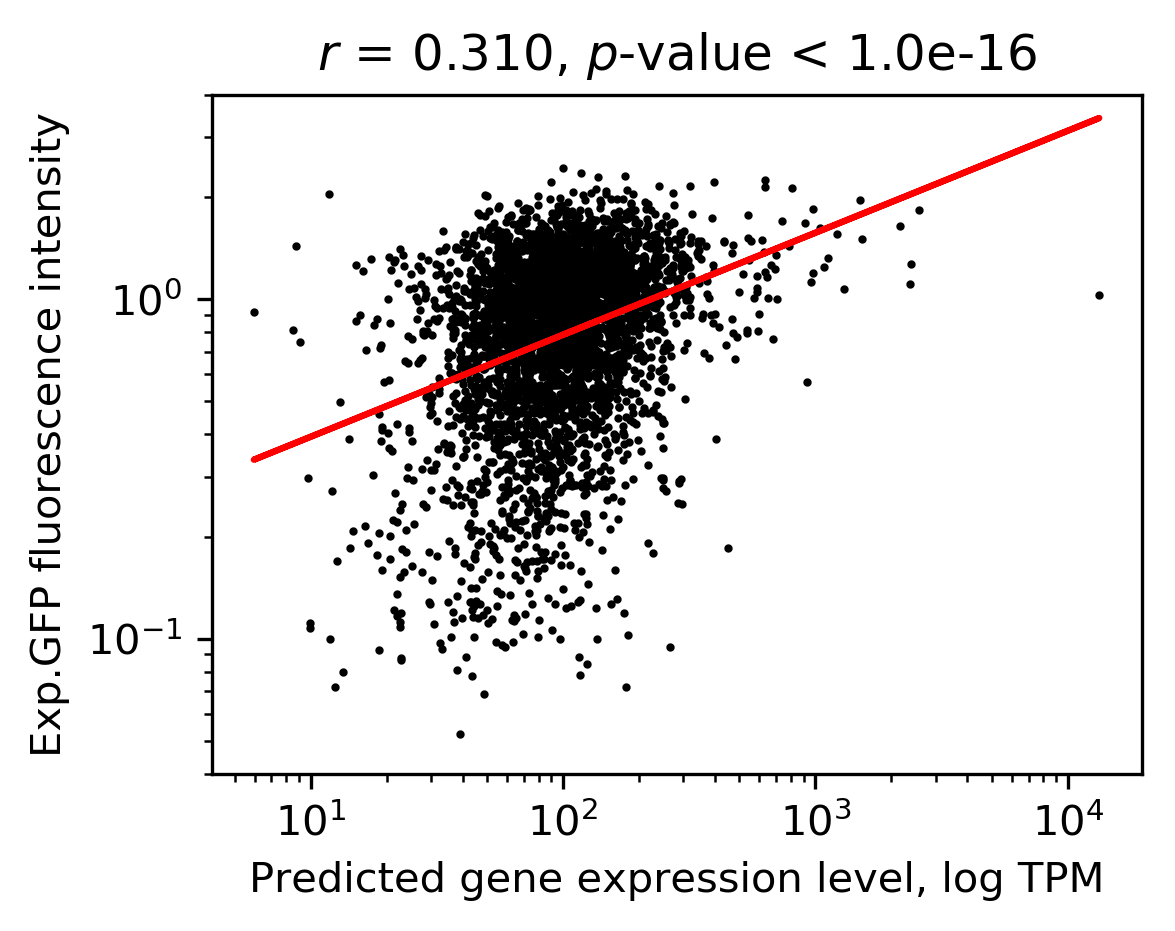

In [19]:
# scatter exp Yamanishi 2013

df_yama = pd.read_csv(folder+fn7)

df_yama
plt.figure(figsize=(4,3))
x = df_yama.ytpm_gfpt.values
y = df_yama.relative_fi.values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(-0.001,0.08)
plt.ylim(0.04,4)
plt.ylabel('Exp.GFP fluorescence intensity')
plt.xlabel('Predicted gene expression level, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
plt.show()

(6111, 22)


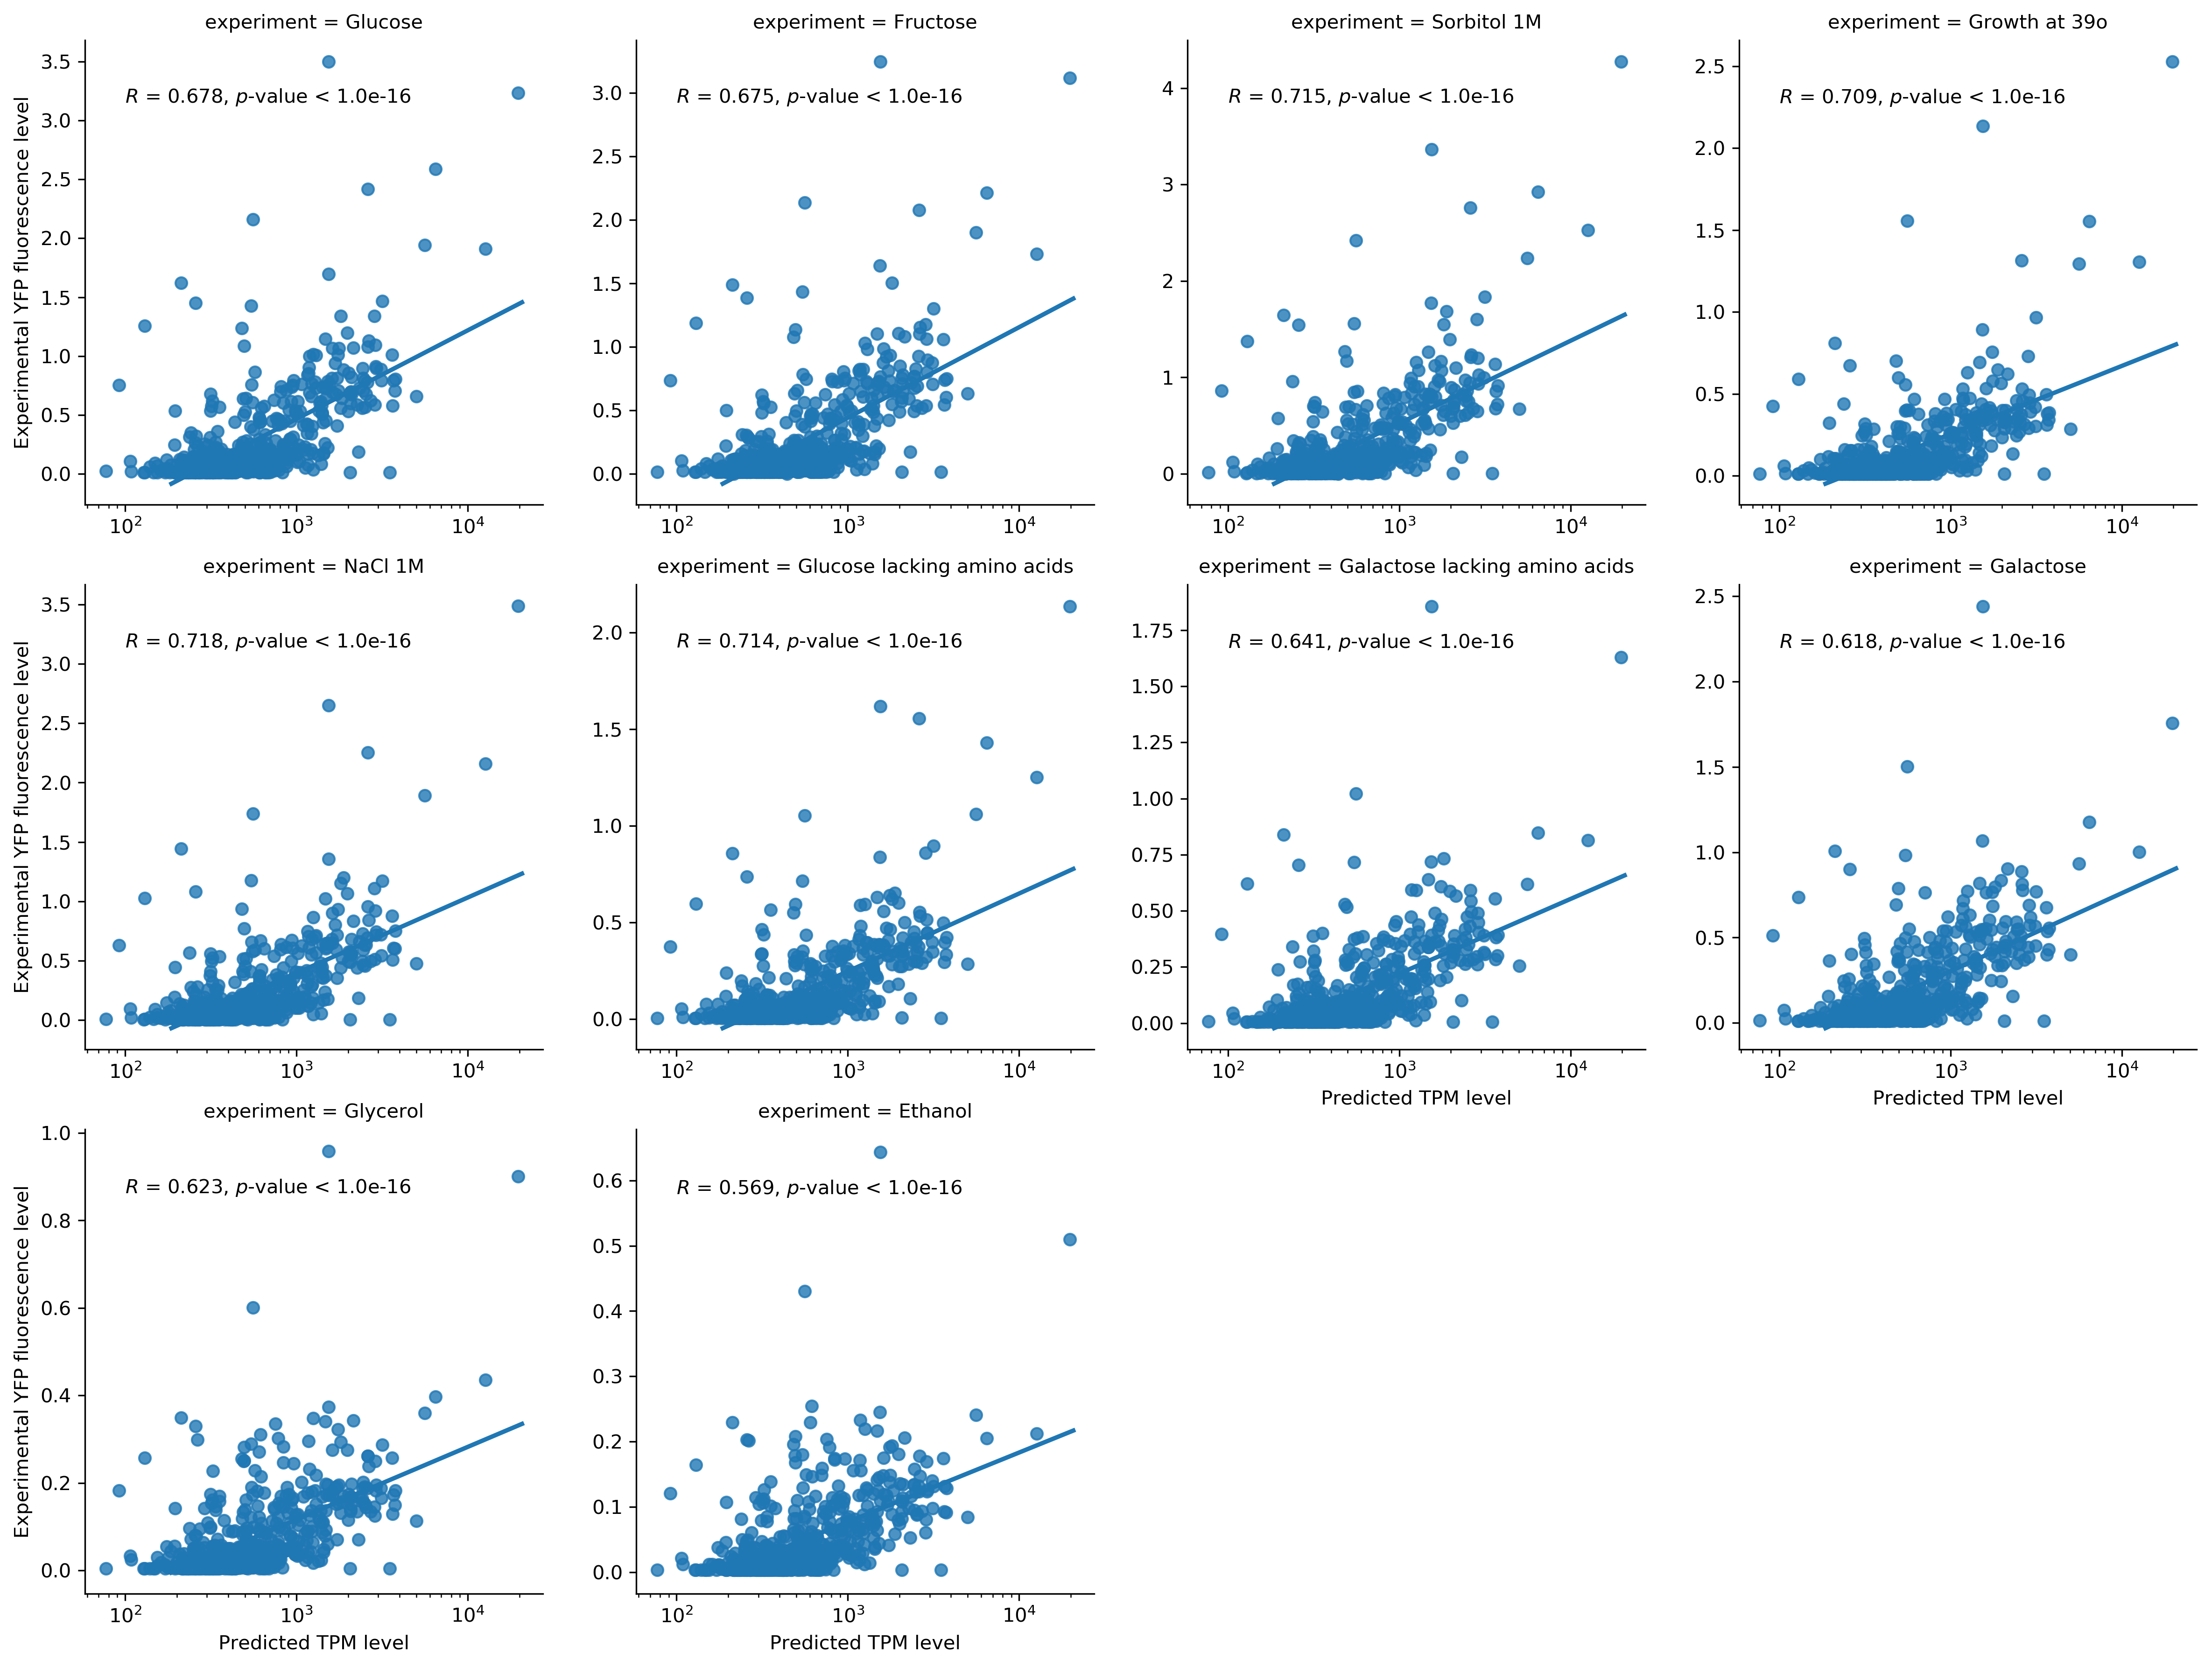

In [20]:
#Figure S1-4. Correlation analysis of predicted expression levels 
# (Methods) with experimentally measured fluorescence intensities 
# across 10 conditions.

datacols = ['Glucose', 'Fructose', 'Sorbitol 1M', 'Growth at 39o', 'NaCl 1M',
        'Glucose lacking amino acids', 'Galactose lacking amino acids',
        'Galactose', 'Glycerol', 'Ethanol']

# stack df on experiments (datacols)
datacols2 = datacols.copy()
#datacols2.extend(['median','Cluster'])
df_keren_stack = df_keren[datacols2].stack().reset_index()
df_keren_stack.columns = ['index','experiment','Experimental YFP fluorescence level']

df_keren2 = df_keren.drop(columns=datacols2).reset_index().merge(df_keren_stack,on='index')
print(df_keren2.shape)

pcc_keren = []
for col in datacols2:
    pcc_keren.append(stats.pearsonr(df_keren.dropna(axis=0,subset=[col]).ytpm_adh1.values,df_keren.dropna(axis=0,subset=[col])[col].values))

pcc_keren = pd.DataFrame([[xx[0],xx[1]] for xx in pcc_keren])
pcc_keren.columns = ['r','p']
pcc_keren.index = datacols2
pcc_keren['p'] = pcc_keren['p'].apply(fix_pvals)

grid = sns.lmplot(data=df_keren2.rename(columns={'ytpm':'Predicted TPM level'}),
                  x='Predicted TPM level',
                  y='Experimental YFP fluorescence level',
                  col='experiment',col_wrap=4,
                 sharex=False,sharey=False,
                 ci=None,logx=True,size=4)
grid.set(xscale="log")#, yscale="log")

k=0
for ax in grid.axes: 
    ax.annotate('$R$ = '+str("%.3f" % pcc_keren.r[k])+ ', $p$-value < '+str("%.1e" % pcc_keren.p[k]),
                xy=(100,df_keren[datacols[k]].max()*0.9))
    k+=1


In [21]:
pcc_keren.columns = ['Pearsons r','p-value']
pcc_keren

,Pearsons r,p-value
Glucose,0.677998,1.000000e-16
Fructose,0.674680,1.000000e-16
Sorbitol 1M,0.714757,1.000000e-16
Growth at 39o,0.708950,1.000000e-16
NaCl 1M,0.717844,1.000000e-16
Glucose lacking amino acids,0.714419,1.000000e-16
Galactose lacking amino acids,0.641039,1.000000e-16
Galactose,0.617531,1.000000e-16
Glycerol,0.622859,1.000000e-16
Ethanol,0.569117,1.000000e-16


# Results model organisms

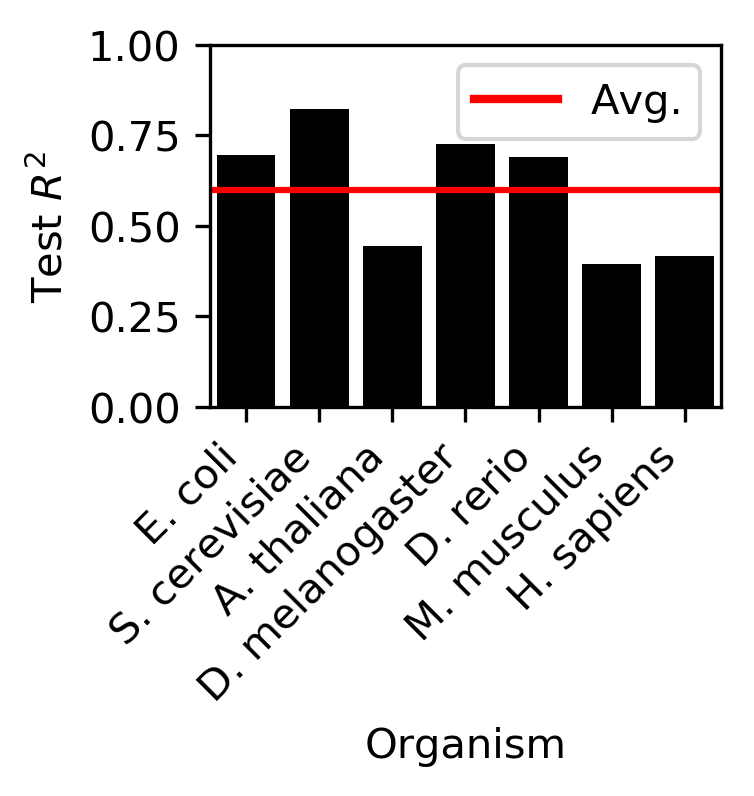

In [22]:
# barplot

df_org = pd.read_csv(folder+fn5, index_col=0).stack().reset_index()
df_org.columns = ['variable','organism','value']
df_org['organism'] = df_org.organism.str.replace('_','. ')
df_org.head()

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2.2,1.6))
f = sns.barplot(data=df_org[df_org.variable=='R2_test'],x='organism',y='value',
           palette=['k'])
plt.plot([-1,10],[0.598,0.598],'r')
plt.xlim(-0.5,6.5)
plt.ylim(0,1)
plt.xlabel('Organism')
plt.ylabel('Test $R^2$')
plt.xticks(rotation=(45),ha='right') #rotation_mode="anchor")
custom_lines = [Line2D([0], [0], color='r', lw=2)]
plt.legend(custom_lines,['Avg.'])
# for ax in f.x:
#     ax.set_xtick

plt.savefig('f1h.svg')

In [23]:
# Figure S1-5. Correlation analysis of genomic complexity to gene 
# expression prediction performance across the model organisms.

tmp =  [el for it in [df_org[df_org.variable=='complexity']['value'].values for i in range(4)] for el in it]
df_org['complexity'] = tmp

data = df_org[df_org.variable!='complexity']
#data = df_org[df_org.variable=='R2_test']
stats.pearsonr(data.value,np.log(data.complexity))


(0.6155092551168377, 0.0029761292895364184)

Text(0.5, 1.0, '$R$ = 0.616, $p$-value < 3.0e-03')

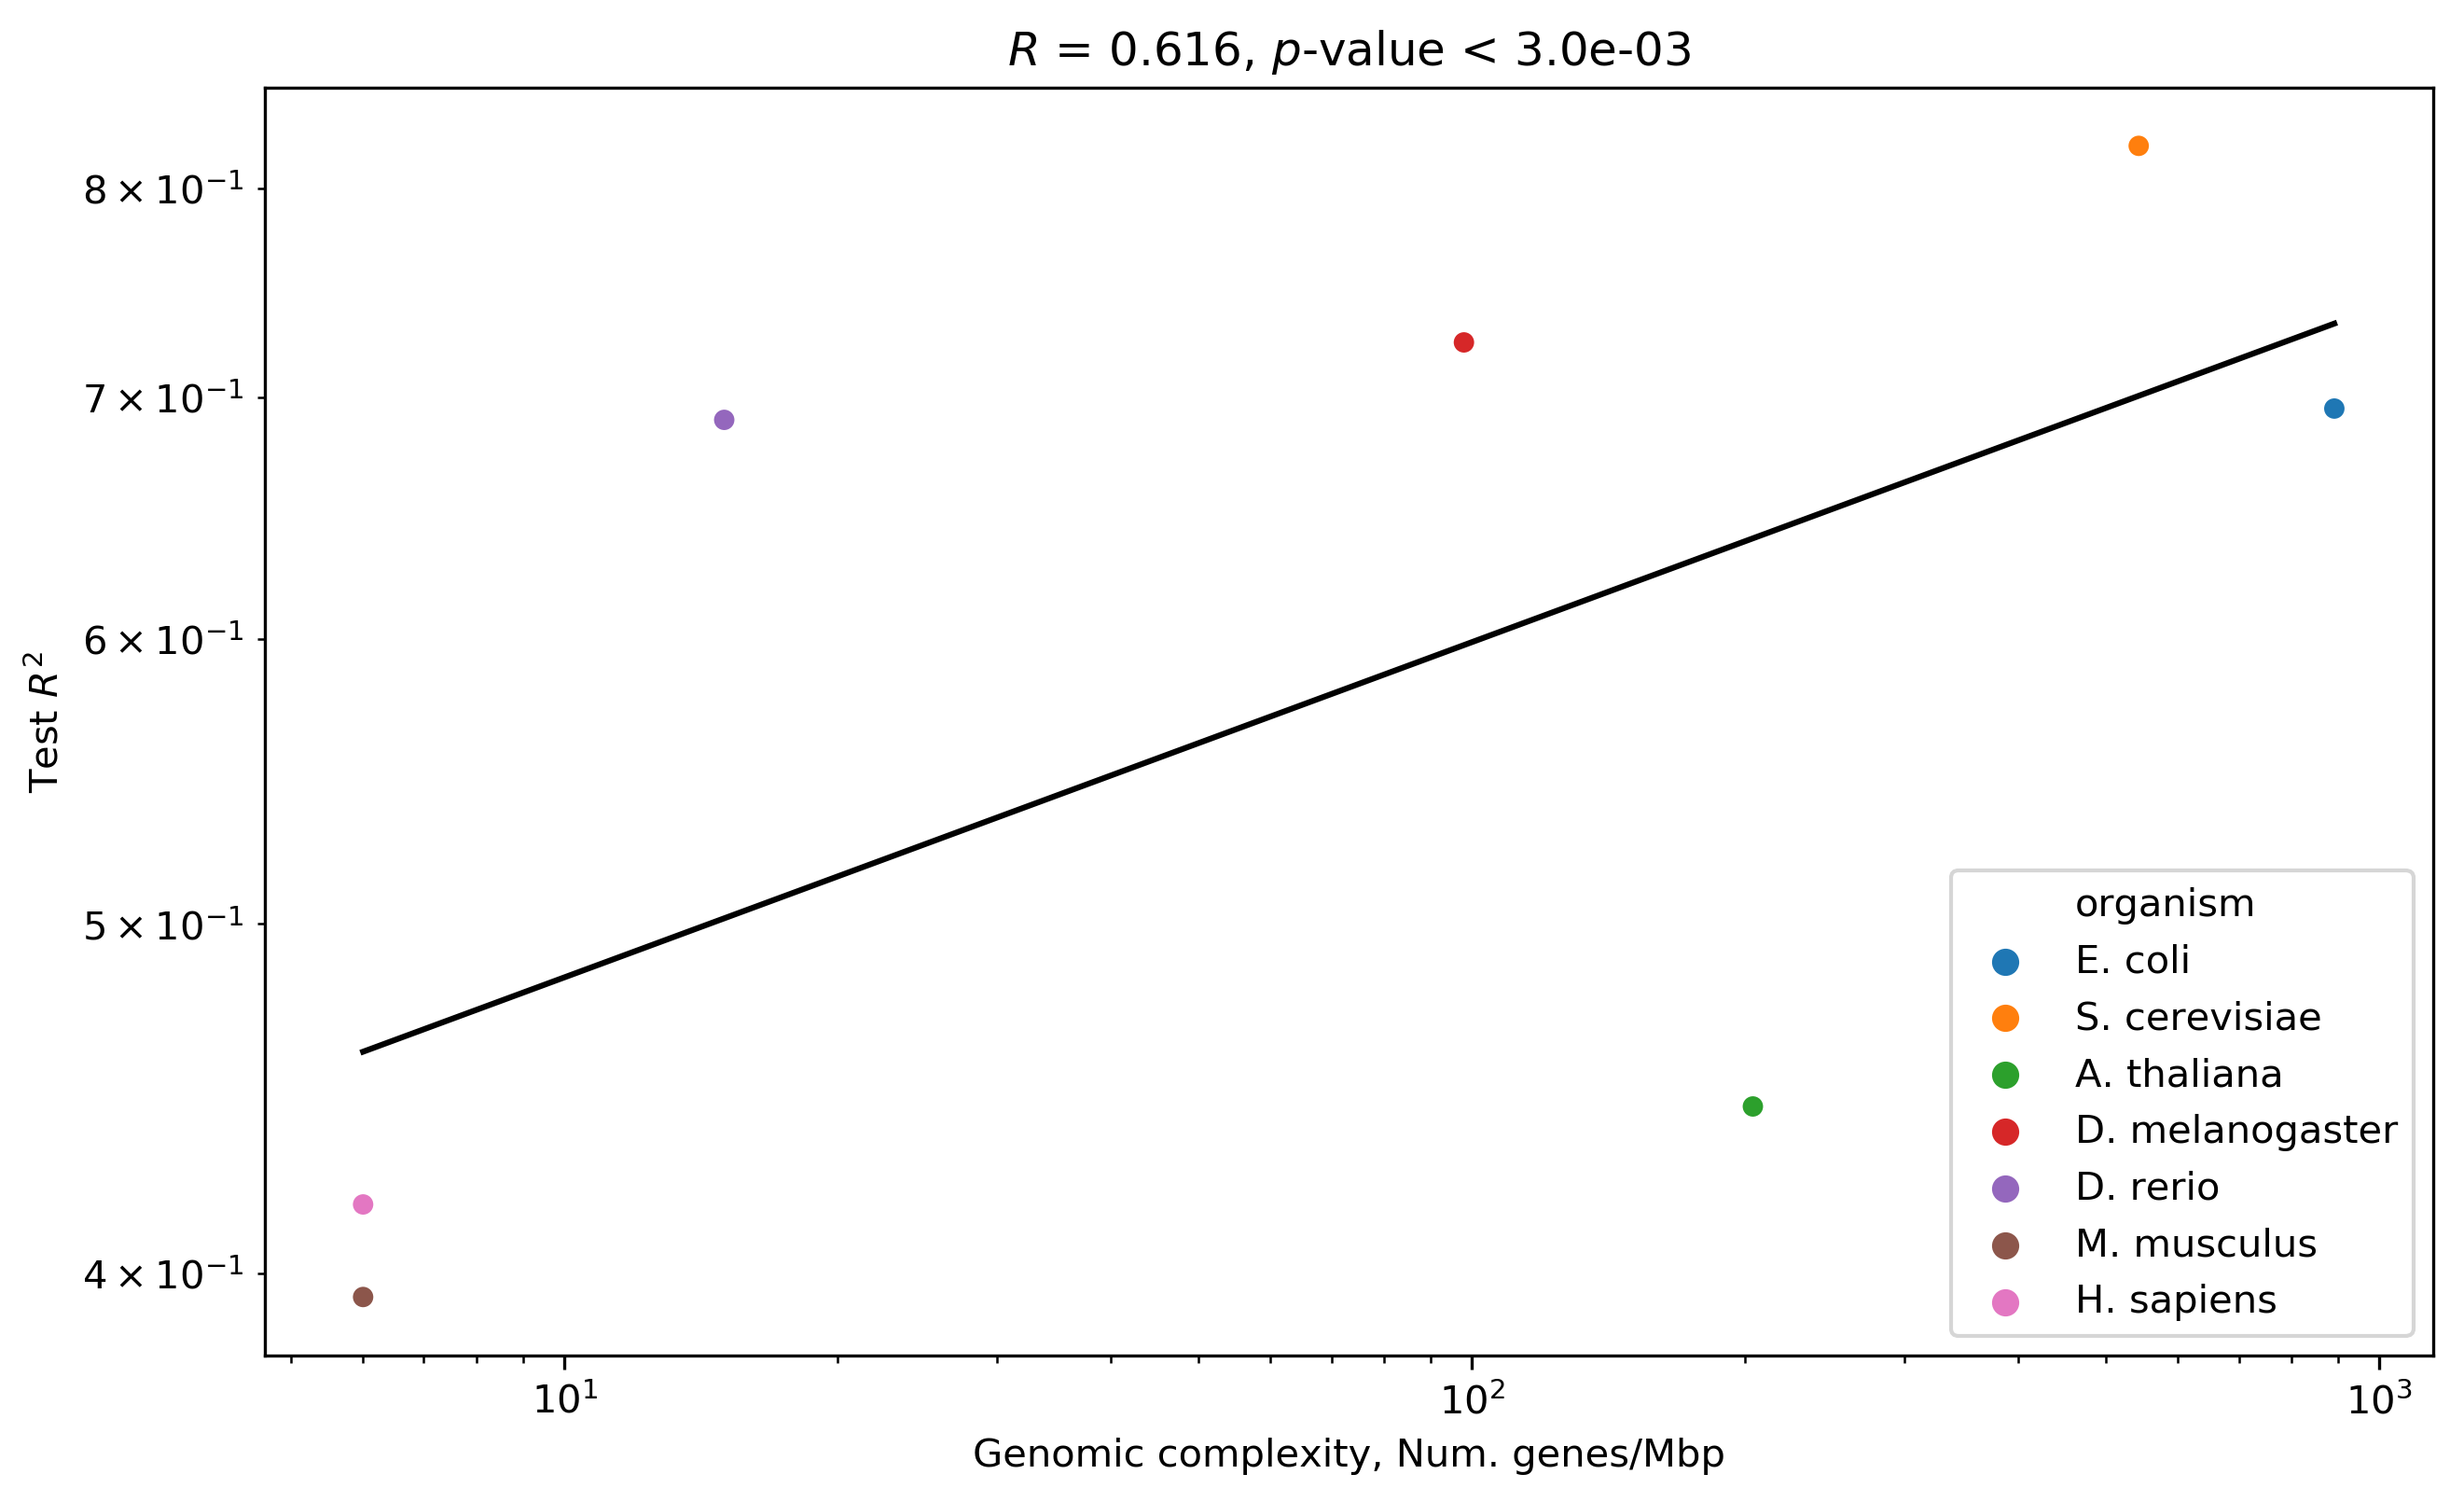

In [24]:
# plt.scatter(data[data.variable=='R2_test'].complexity,
#             data[data.variable=='R2_test'].value)
# plt.xscale('log')

plt.figure(figsize=(10,6))
y = data[data.variable=='R2_test'].value
x = data[data.variable=='R2_test'].complexity

sns.scatterplot(data=data[data.variable=='R2_test'],
         x='complexity',y='value',hue='organism')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')

# plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'k', label='fitted line')
rvalue,pvalue = stats.pearsonr(data.value,np.log(data.complexity))
plt.xlabel('Genomic complexity, Num. genes/Mbp')
plt.ylabel('Test $R^2$')
plt.title('$R$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))

